# Classifying blood plasma and blood serum with increasing training set size (Fig6)

In [16]:
import Classification_Utils as cu
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import learning_curve, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler, StandardScaler

## Load and clean data

In [17]:
df = pd.read_csv('SerumPlasmaPeptideQuant.txt', sep='\t', index_col='Peptide')
print(df.shape)

(9447, 119)


## Map each column to a corresponding label

In [18]:
tissues = ['Blood_Plasma', 'Blood_Serum']
tissues_to_columns = cu.map_tissues_to_columns(df, tissues)

In [19]:
column_names = df.columns.values.tolist()
labels = cu.get_labels(column_names, tissues_to_columns)

## Reduce dataframe to smaller number of peptides

In [20]:
import math

def keep_percentile_peptides(df, labels, tissues, percentile, impute_val):
    
    df = df.T
    tissue_dfs = []
    
    for tissue in tissues:
        cols_to_drop = [col for col in df.columns.values if not col.startswith(tissue)]
        tissue_df = df.drop(cols_to_drop, axis=1)
        
        ### Drop rows with nothing observed
        tissue_df.replace(impute_val, np.nan, inplace=True)
        tissue_df.dropna(axis=0, how='all', inplace=True)
        tissue_df.replace(np.nan, impute_val, inplace=True)
        
        peptide_mean_abundances = tissue_df.mean(axis=1) # pandas series

        # sort by average abundance value, drop below threshold
        peptide_mean_abundances.sort_values(ascending=False, inplace=True)
        num_peptides_to_keep = math.ceil(len(peptide_mean_abundances) * percentile/100)
        peptides_to_drop = peptide_mean_abundances[num_peptides_to_keep:].index.values
        
        tissue_df.drop(peptides_to_drop, axis=0, inplace=True)
        
        tissue_dfs.append(tissue_df)
        
    # join dataframes
    combined_df = pd.DataFrame()
    for next_df in tissue_dfs:
        combined_df = combined_df.join(next_df, how='outer')
    
    combined_df.replace(np.nan, impute_val, inplace=True)
        
    return combined_df.T

In [21]:
imputed_val = df.mode().iloc[0, 0]

print(df.shape)
df = keep_percentile_peptides(df.T, labels, tissues, 45, imputed_val).T
print(df.shape)

(9447, 119)
(4983, 119)


In [22]:
std_scaler = StandardScaler()
df = std_scaler.fit_transform(df)

min_max_scaler = MinMaxScaler()
min_max_df = min_max_scaler.fit_transform(df)

## Plot Learning Curves
* Print each classifier's result for each training size; this data was used to create Fig6

Modified from http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py

In [23]:
def plot_learning_curve(estimator, title, data, labels, ylim=None,
                        cv=StratifiedShuffleSplit(n_splits=100, test_size=.3, random_state=0),
                        n_jobs=1, train_sizes=[20, 30, 40, 50]):
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Samples per Tissue")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, data, labels, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)

    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    print('Mean test set scores: ', test_scores_mean)
        
    plt.grid()

    plt.fill_between(train_sizes/2, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="r")
    ### Train sizes = combined plasma + serum. Divide by 2 to get size per tissue
    plt.plot(train_sizes/2, test_scores_mean, 'o-', color="r",
             label="Test Set Accuracy Score")

    return plt

In [24]:
models = [LogisticRegression(random_state=0), 
          RandomForestClassifier(random_state=0), 
          SVC(kernel='linear', random_state=0),
          GradientBoostingClassifier(random_state=0), 
          GaussianNB(), 
          KNeighborsClassifier()]

model_names = ['Logistic Regression', 
               'Random Forest', 
               'SVC', 
               'Gradient Boosting', 
               'Gaussian Naive Bayes', 
               'K-Nearest Neighbors']


*** Logistic Regression :
Mean test set scores:  [ 0.73694444  0.79944444  0.82972222  0.83888889  0.85666667  0.86972222
  0.87361111  0.88444444]


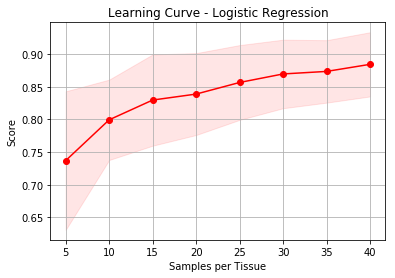


*** Random Forest :
Mean test set scores:  [ 0.73388889  0.79472222  0.81111111  0.81916667  0.8325      0.83111111
  0.83722222  0.84027778]


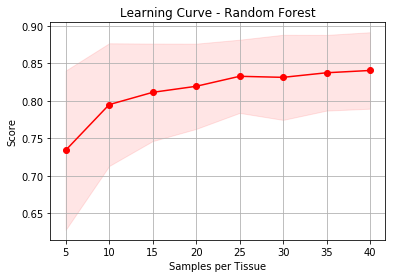


*** SVC :
Mean test set scores:  [ 0.73805556  0.80888889  0.82888889  0.84194444  0.86055556  0.86916667
  0.87861111  0.89055556]


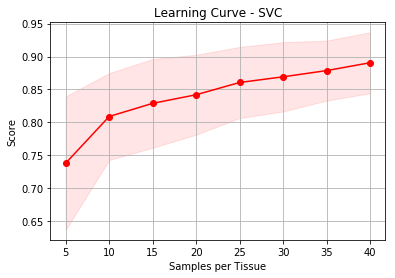


*** Gradient Boosting :
Mean test set scores:  [ 0.74888889  0.76305556  0.775       0.77638889  0.77638889  0.78305556
  0.79583333  0.79722222]


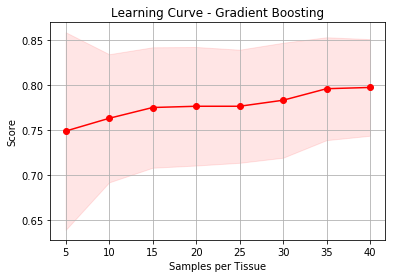


*** Gaussian Naive Bayes :
Mean test set scores:  [ 0.51861111  0.53527778  0.57138889  0.64166667  0.6975      0.7575
  0.79472222  0.82055556]


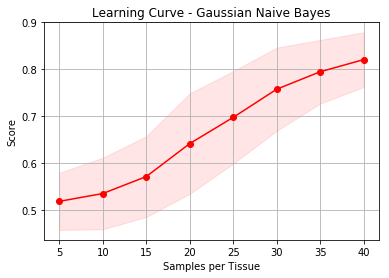


*** K-Nearest Neighbors :
Mean test set scores:  [ 0.55583333  0.76277778  0.81083333  0.82333333  0.83277778  0.84388889
  0.84111111  0.85305556]


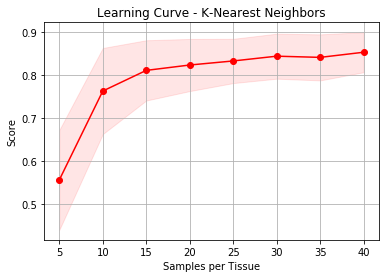

In [25]:
for clf, name in zip(models, model_names):
    print('\n***', name, ':')
    plt = plot_learning_curve(clf, 'Learning Curve - ' + name, df.T, labels, train_sizes = [10, 20, 30, 40, 50, 60, 70, 80])
    plt.show()
    plt.clf()



*** Multinomial Naive Bayes:
Mean test set scores:  [ 0.56527778  0.75833333  0.8         0.82333333  0.83555556  0.84916667
  0.85944444  0.87638889]


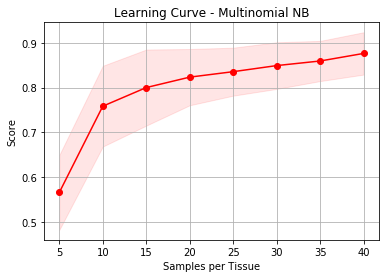

In [27]:
print('\n*** Multinomial Naive Bayes:')
plt = plot_learning_curve(clf, 'Learning Curve - Multinomial NB', min_max_df.T,
                          labels, train_sizes = [10, 20, 30, 40, 50, 60, 70, 80])

plt.show()
plt.clf()